<center><font color = "green"><h1>PUBG Prediction</h1></font></center>

# Table Content
###  1) Importing Libraries
###  2) Reading Data
###  3) Data Wrangling
###  4) Feature Engineering
### 5) ML - CatBoost Model

# Importing Libraries

In [1]:
!pip install catboost

     -------------------------------------- 101.0/101.0 MB 7.2 MB/s eta 0:00:00


In [2]:
# handling warnings
import warnings
warnings.filterwarnings("ignore")

# standard libraries
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)

import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Reading the Data

In [3]:
# load the data
df = pd.read_csv("PUBG_Game_Prediction_data.csv")

In [4]:
# glimpse of the data
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
# data dimension
df.shape

(4446966, 29)

In [6]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

# Data Wrangling

### Check for the rows with missing win prediction value

In [7]:
# check row with NULL win prediction value
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [8]:
# remove the data row
df.drop(2744604, inplace = True)

### Understanding Players distribution in a game

In [9]:
# prepare new parameter to know how many players are in a game
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

In [10]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


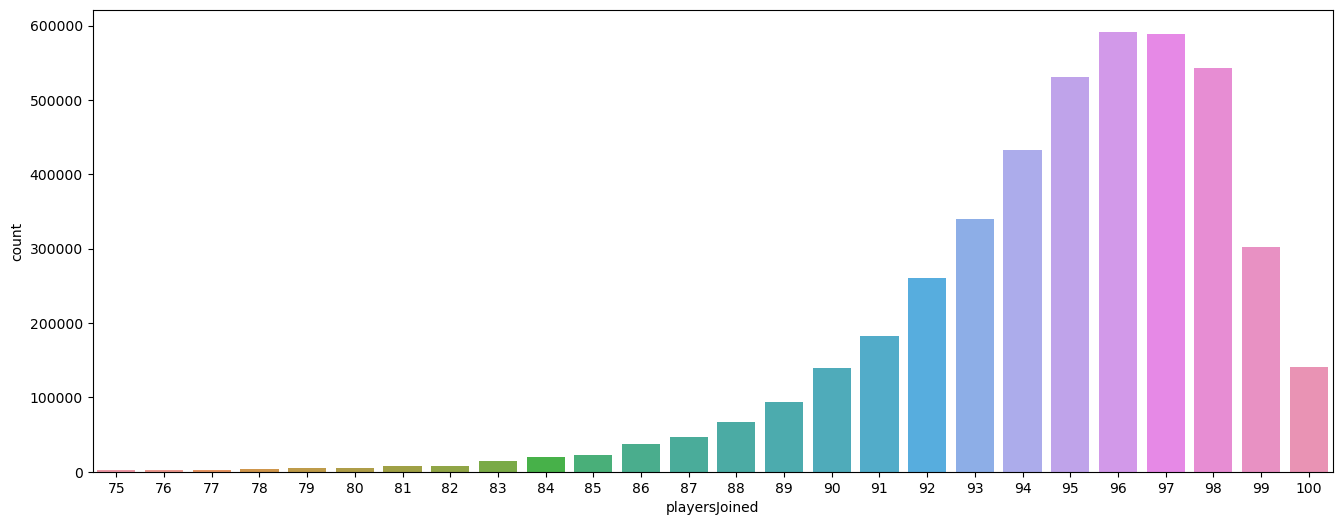

In [11]:
sns.countplot(df[df['playersJoined']>=75]['playersJoined'])
plt.show()

## Analysing the Data

### Kills without moving?

In [12]:
# prepare a data parameter to gather the information of the total distance travelled
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

# prepare a data parameter to check for anamoly detection that
# the person has not moved but still managed to do the kills
df['killswithoutMoving'] = ((df['kills']>0) & (df['totalDistance'] ==0))

In [13]:
df[df['killswithoutMoving'] == True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killswithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


In [14]:
df[df['killswithoutMoving'] == True].shape

(1535, 32)

In [15]:
# drop the table
df.drop(df[df['killswithoutMoving'] == True].index , inplace = True)

### Extra Ordinary Road Kills???

In [16]:
df[df['roadKills'] > 5].shape

(46, 32)

In [17]:
df.drop(df[df['roadKills'] > 5].index, inplace = True)

### So many kills, HOW????

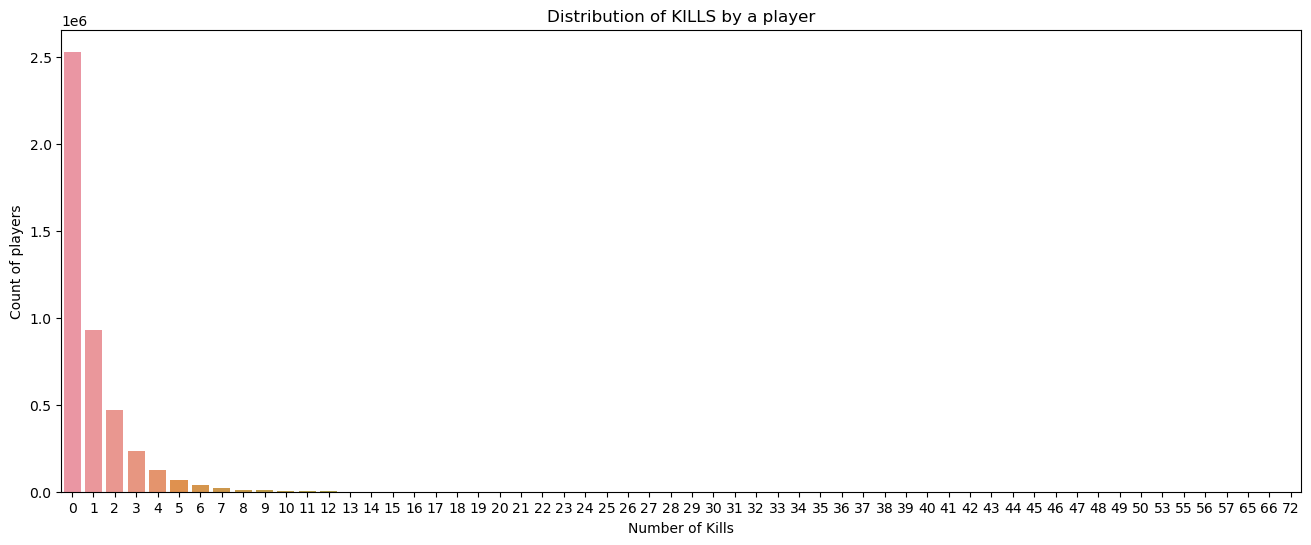

In [18]:
sns.countplot(data = df, x = df['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

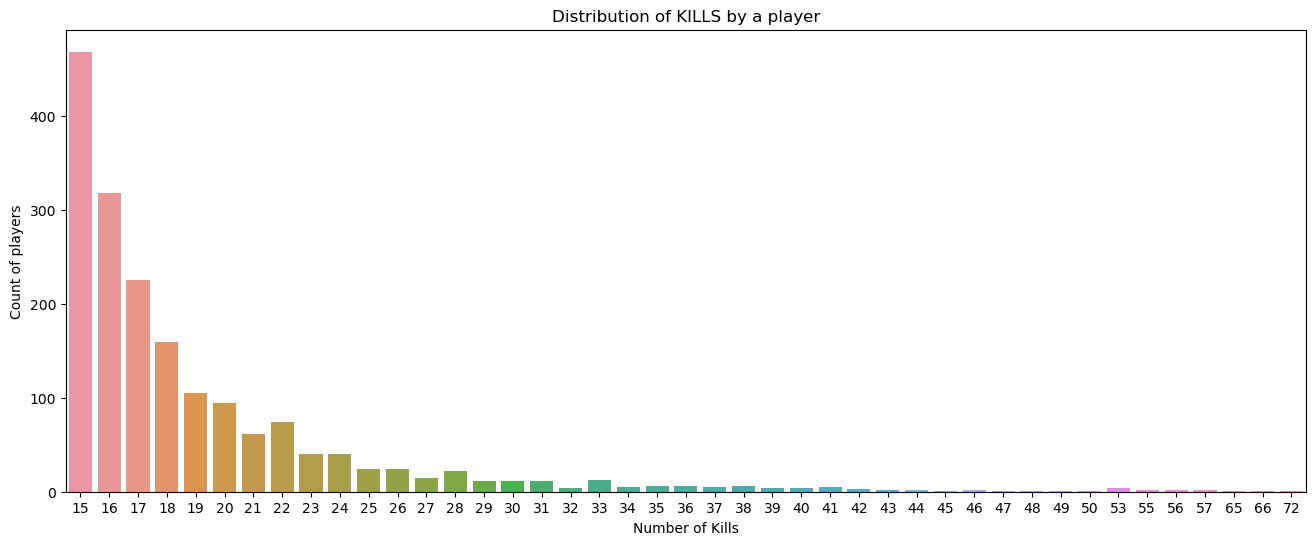

In [22]:
sns.countplot(df[df['kills']>=15]['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

In [23]:
# data dimension
df[df['kills'] > 20].shape

(417, 32)

In [24]:
# drop the instances
df.drop(df[df['kills'] > 20].index, inplace = True)

### Head Shot

In [25]:
df['headshot_rate'] = df['headshotKills']/df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

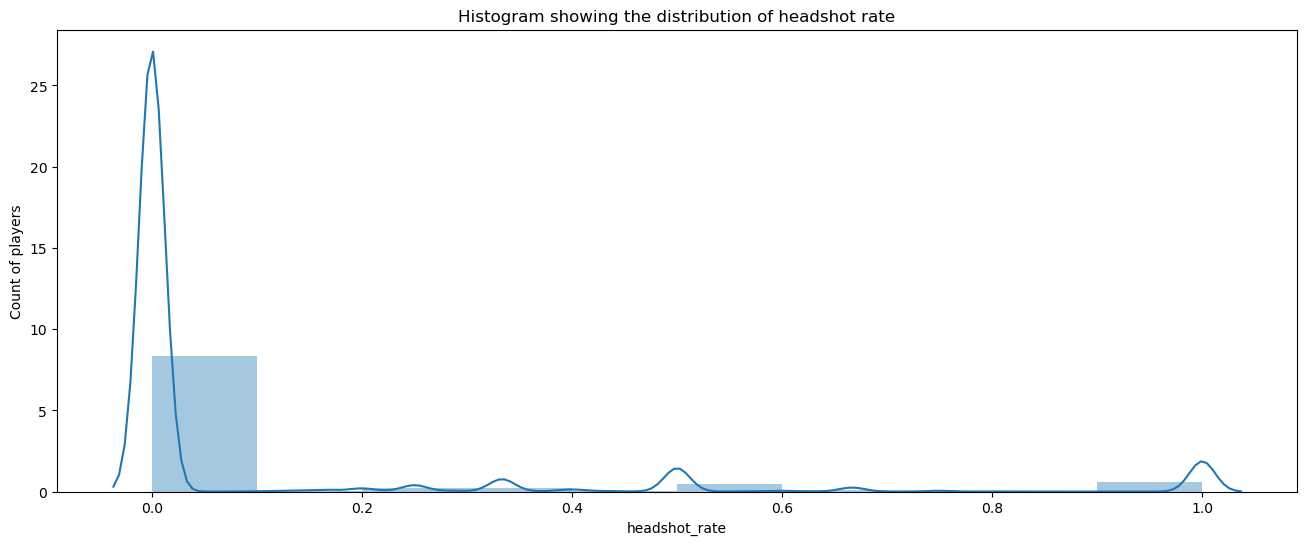

In [26]:
# plot the headshot rate distribution
sns.distplot(df['headshot_rate'], bins =10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [27]:
df[(df['headshot_rate'] ==1) & (df['kills']>5)].shape

(187, 33)

In [28]:
df.drop(df[(df['headshot_rate'] == 1)& (df['kills'] > 6)].index, inplace = True)

### Longest Shot

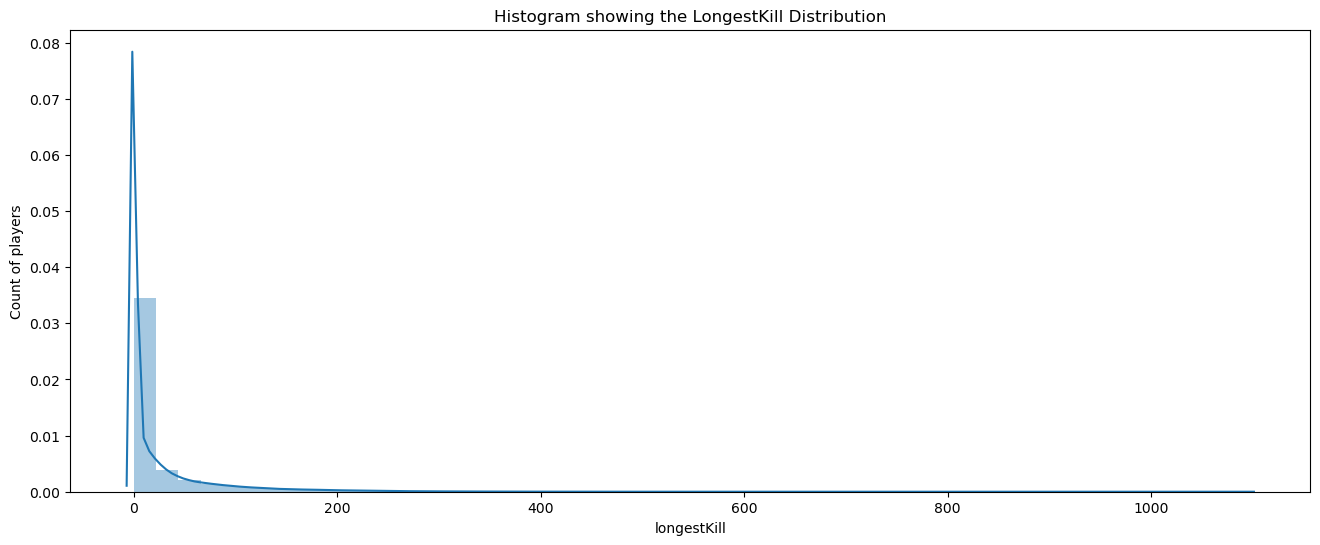

In [29]:
sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the LongestKill Distribution")
plt.ylabel("Count of players")
plt.show()

In [30]:
df[df['longestKill']>=500].shape

(1747, 33)

In [31]:
df.drop(df[df['longestKill']>=500].index, inplace = True)

### Weapon Change

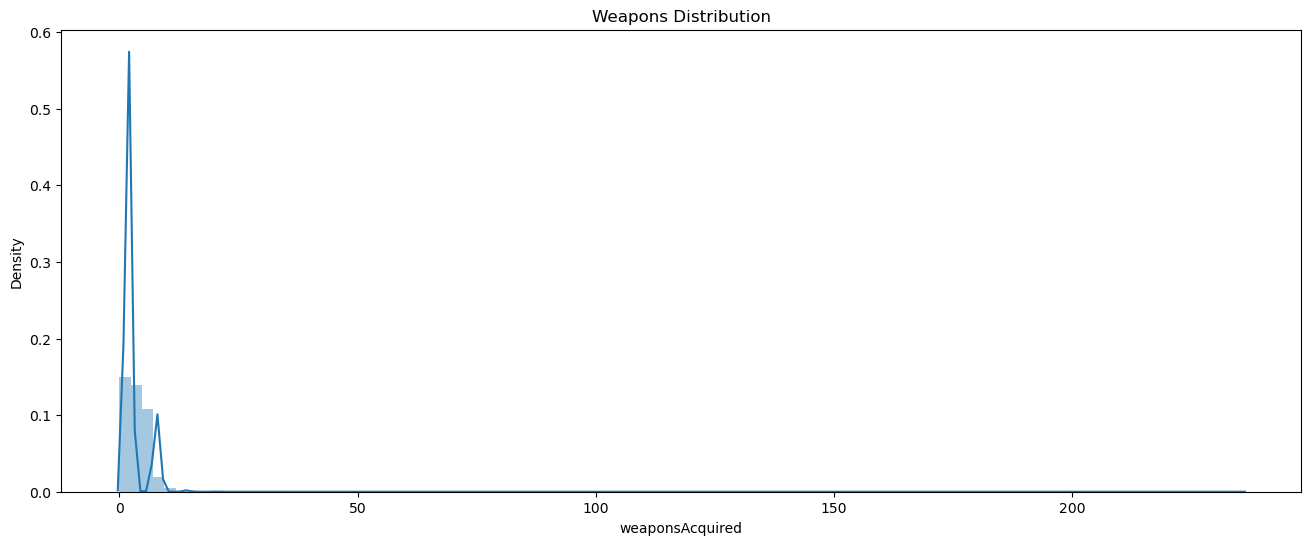

In [32]:
sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [33]:
df[df['weaponsAcquired']>=15].shape

(6809, 33)

In [34]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

### EDA

In [35]:
df.shape

(4436306, 33)

In [36]:
df.isnull().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
dtype: int64

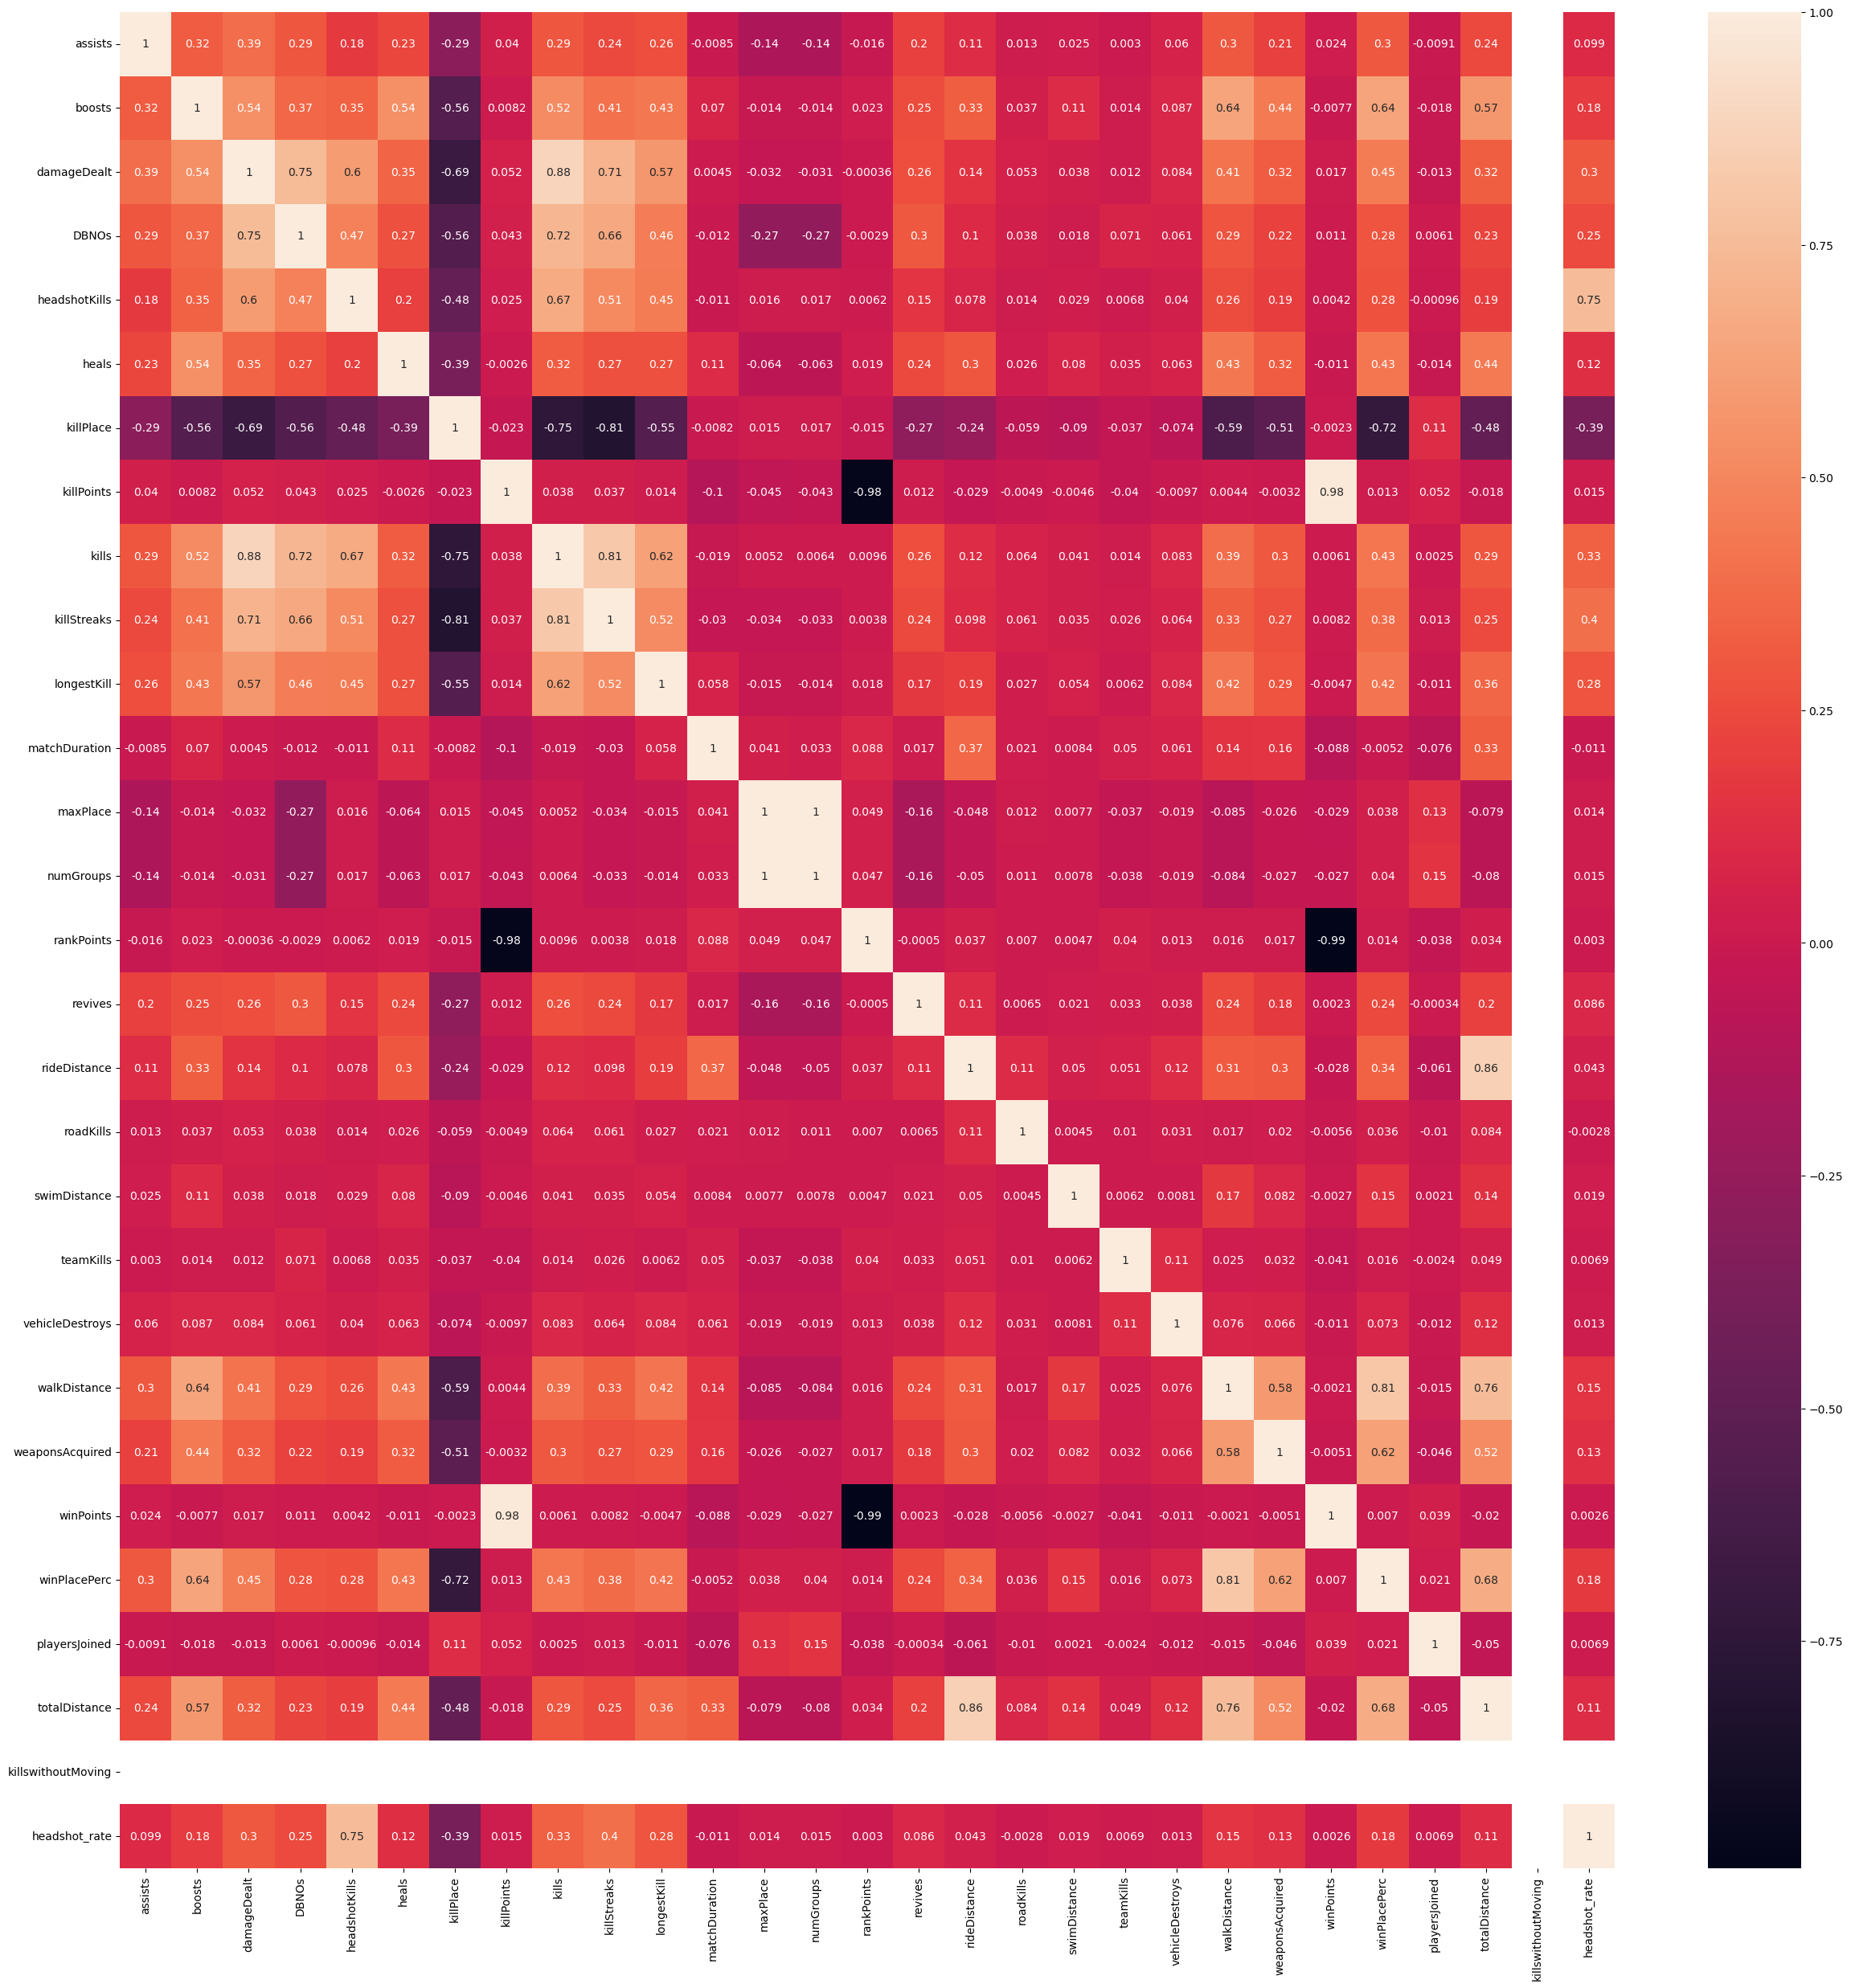

In [39]:
# correlation of parameter with Win Prediction
plt.figure(figsize=[30,30])
sns.heatmap(df.corr(), annot = True)
plt.show()

# Feature Engineering

In [40]:
normalising_factor = (100 - df['playersJoined']/100)+1

In [41]:
df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor


df['traveldistance'] = df['walkDistance'] + df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [43]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutMoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsnboosts', 'assist'],
      dtype='object')

In [44]:
data = df.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance', 
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])

In [45]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,killswithoutMoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


## ML - CatBoost Model

### Splitting the input and result 

In [61]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [62]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,killswithoutMoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


In [63]:
y.head()

0    0.4444
1    0.6400
2    0.7755
3    0.1667
4    0.1875
Name: winPlacePerc, dtype: float64

### Handling Categorical Data

In [64]:
x = pd.get_dummies(x, columns = ['matchType', 'killswithoutMoving'])
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


In [65]:
x.shape

(4436306, 40)

In [67]:
features = x.columns

### Scaling Data

In [52]:
sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

In [53]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.765100,-0.459622,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.765100,-0.459622,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
2,-0.582937,-0.384018,-0.024245,-0.804728,-0.765100,-0.459622,0.169557,0.813067,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,-0.808936,0.0
3,-0.582937,-0.384018,0.995795,-0.804728,-0.765100,-0.459622,-0.560992,0.700391,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
4,-0.582937,-0.384018,-0.097105,-0.804728,0.647633,0.727371,2.232284,0.906738,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,2.696896,-0.405071,-0.808936,0.0


### Splitting the Data

In [54]:
xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size = 0.3, random_state = 0)

In [55]:
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(3105414, 40) (3105414,)
(1330892, 40) (1330892,)


### CatBoost Model

In [56]:
import catboost as cb

In [57]:
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [58]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [59]:
# GRID Search

grid = {'iterations': [100, 150], 
       'learning_rate': [0.03, 0.1], 
       'depth': [2, 4, 6, 8]}

model.grid_search(grid, train_dataset)

0:	learn: 0.5482016	test: 0.5479886	best: 0.5479886 (0)	total: 257ms	remaining: 25.4s
1:	learn: 0.5333650	test: 0.5331566	best: 0.5331566 (1)	total: 371ms	remaining: 18.2s
2:	learn: 0.5189826	test: 0.5187815	best: 0.5187815 (2)	total: 486ms	remaining: 15.7s
3:	learn: 0.5050844	test: 0.5048926	best: 0.5048926 (3)	total: 600ms	remaining: 14.4s
4:	learn: 0.4916276	test: 0.4914432	best: 0.4914432 (4)	total: 725ms	remaining: 13.8s
5:	learn: 0.4786251	test: 0.4784449	best: 0.4784449 (5)	total: 835ms	remaining: 13.1s
6:	learn: 0.4660267	test: 0.4658539	best: 0.4658539 (6)	total: 939ms	remaining: 12.5s
7:	learn: 0.4538495	test: 0.4536820	best: 0.4536820 (7)	total: 1.05s	remaining: 12s
8:	learn: 0.4420341	test: 0.4418693	best: 0.4418693 (8)	total: 1.16s	remaining: 11.7s
9:	learn: 0.4306331	test: 0.4304748	best: 0.4304748 (9)	total: 1.27s	remaining: 11.5s
10:	learn: 0.4195967	test: 0.4194453	best: 0.4194453 (10)	total: 1.39s	remaining: 11.2s
11:	learn: 0.4089243	test: 0.4087765	best: 0.4087765 (

94:	learn: 0.1398785	test: 0.1399700	best: 0.1399700 (94)	total: 11.2s	remaining: 591ms
95:	learn: 0.1394478	test: 0.1395405	best: 0.1395405 (95)	total: 11.3s	remaining: 473ms
96:	learn: 0.1390753	test: 0.1391697	best: 0.1391697 (96)	total: 11.5s	remaining: 355ms
97:	learn: 0.1387199	test: 0.1388151	best: 0.1388151 (97)	total: 11.6s	remaining: 237ms
98:	learn: 0.1383766	test: 0.1384732	best: 0.1384732 (98)	total: 11.7s	remaining: 118ms
99:	learn: 0.1380397	test: 0.1381367	best: 0.1381367 (99)	total: 11.8s	remaining: 0us

bestTest = 0.1381366755
bestIteration = 99

0:	loss: 0.1381367	best: 0.1381367 (0)	total: 13.9s	remaining: 3m 27s
0:	learn: 0.5126068	test: 0.5124096	best: 0.5124096 (0)	total: 137ms	remaining: 13.6s
1:	learn: 0.4671679	test: 0.4669991	best: 0.4669991 (1)	total: 256ms	remaining: 12.5s
2:	learn: 0.4264429	test: 0.4262951	best: 0.4262951 (2)	total: 374ms	remaining: 12.1s
3:	learn: 0.3902182	test: 0.3900853	best: 0.3900853 (3)	total: 490ms	remaining: 11.7s
4:	learn: 0.358

88:	learn: 0.1174285	test: 0.1176647	best: 0.1176647 (88)	total: 9.66s	remaining: 1.19s
89:	learn: 0.1171031	test: 0.1173483	best: 0.1173483 (89)	total: 9.77s	remaining: 1.08s
90:	learn: 0.1170075	test: 0.1172519	best: 0.1172519 (90)	total: 9.87s	remaining: 977ms
91:	learn: 0.1169191	test: 0.1171636	best: 0.1171636 (91)	total: 9.98s	remaining: 867ms
92:	learn: 0.1168242	test: 0.1170669	best: 0.1170669 (92)	total: 10.1s	remaining: 759ms
93:	learn: 0.1167374	test: 0.1169829	best: 0.1169829 (93)	total: 10.2s	remaining: 650ms
94:	learn: 0.1166427	test: 0.1168850	best: 0.1168850 (94)	total: 10.3s	remaining: 541ms
95:	learn: 0.1165224	test: 0.1167628	best: 0.1167628 (95)	total: 10.4s	remaining: 433ms
96:	learn: 0.1164136	test: 0.1166544	best: 0.1166544 (96)	total: 10.5s	remaining: 325ms
97:	learn: 0.1163231	test: 0.1165631	best: 0.1165631 (97)	total: 10.6s	remaining: 217ms
98:	learn: 0.1162409	test: 0.1164784	best: 0.1164784 (98)	total: 10.7s	remaining: 108ms
99:	learn: 0.1161663	test: 0.116

81:	learn: 0.1466753	test: 0.1467577	best: 0.1467577 (81)	total: 9.04s	remaining: 7.5s
82:	learn: 0.1459917	test: 0.1460750	best: 0.1460750 (82)	total: 9.15s	remaining: 7.39s
83:	learn: 0.1453945	test: 0.1454773	best: 0.1454773 (83)	total: 9.25s	remaining: 7.27s
84:	learn: 0.1448061	test: 0.1448892	best: 0.1448892 (84)	total: 9.36s	remaining: 7.15s
85:	learn: 0.1441889	test: 0.1442730	best: 0.1442730 (85)	total: 9.46s	remaining: 7.04s
86:	learn: 0.1436574	test: 0.1437424	best: 0.1437424 (86)	total: 9.57s	remaining: 6.93s
87:	learn: 0.1431242	test: 0.1432099	best: 0.1432099 (87)	total: 9.67s	remaining: 6.81s
88:	learn: 0.1425612	test: 0.1426476	best: 0.1426476 (88)	total: 9.78s	remaining: 6.7s
89:	learn: 0.1420826	test: 0.1421694	best: 0.1421694 (89)	total: 9.89s	remaining: 6.59s
90:	learn: 0.1416257	test: 0.1417131	best: 0.1417131 (90)	total: 9.99s	remaining: 6.48s
91:	learn: 0.1411888	test: 0.1412785	best: 0.1412785 (91)	total: 10.1s	remaining: 6.37s
92:	learn: 0.1407061	test: 0.14079

25:	learn: 0.1428209	test: 0.1429318	best: 0.1429318 (25)	total: 2.92s	remaining: 13.9s
26:	learn: 0.1411019	test: 0.1412206	best: 0.1412206 (26)	total: 3.03s	remaining: 13.8s
27:	learn: 0.1397763	test: 0.1398917	best: 0.1398917 (27)	total: 3.14s	remaining: 13.7s
28:	learn: 0.1385976	test: 0.1387311	best: 0.1387311 (28)	total: 3.24s	remaining: 13.5s
29:	learn: 0.1374581	test: 0.1375932	best: 0.1375932 (29)	total: 3.35s	remaining: 13.4s
30:	learn: 0.1362990	test: 0.1364387	best: 0.1364387 (30)	total: 3.46s	remaining: 13.3s
31:	learn: 0.1354159	test: 0.1355534	best: 0.1355534 (31)	total: 3.56s	remaining: 13.1s
32:	learn: 0.1346504	test: 0.1347928	best: 0.1347928 (32)	total: 3.66s	remaining: 13s
33:	learn: 0.1337834	test: 0.1339284	best: 0.1339284 (33)	total: 3.77s	remaining: 12.9s
34:	learn: 0.1330728	test: 0.1332271	best: 0.1332271 (34)	total: 3.87s	remaining: 12.7s
35:	learn: 0.1324924	test: 0.1326522	best: 0.1326522 (35)	total: 3.97s	remaining: 12.6s
36:	learn: 0.1318372	test: 0.13200

119:	learn: 0.1134379	test: 0.1136698	best: 0.1136698 (119)	total: 13.2s	remaining: 3.29s
120:	learn: 0.1133694	test: 0.1135985	best: 0.1135985 (120)	total: 13.3s	remaining: 3.18s
121:	learn: 0.1133185	test: 0.1135468	best: 0.1135468 (121)	total: 13.4s	remaining: 3.06s
122:	learn: 0.1132164	test: 0.1134445	best: 0.1134445 (122)	total: 13.5s	remaining: 2.95s
123:	learn: 0.1131634	test: 0.1133929	best: 0.1133929 (123)	total: 13.6s	remaining: 2.84s
124:	learn: 0.1128980	test: 0.1131247	best: 0.1131247 (124)	total: 13.7s	remaining: 2.73s
125:	learn: 0.1126908	test: 0.1129179	best: 0.1129179 (125)	total: 13.8s	remaining: 2.63s
126:	learn: 0.1125661	test: 0.1127893	best: 0.1127893 (126)	total: 13.9s	remaining: 2.52s
127:	learn: 0.1122374	test: 0.1124655	best: 0.1124655 (127)	total: 14s	remaining: 2.4s
128:	learn: 0.1121722	test: 0.1123991	best: 0.1123991 (128)	total: 14.1s	remaining: 2.29s
129:	learn: 0.1121204	test: 0.1123445	best: 0.1123445 (129)	total: 14.2s	remaining: 2.18s
130:	learn: 0

62:	learn: 0.1496426	test: 0.1497763	best: 0.1497763 (62)	total: 10.1s	remaining: 5.92s
63:	learn: 0.1480579	test: 0.1481975	best: 0.1481975 (63)	total: 10.2s	remaining: 5.75s
64:	learn: 0.1465855	test: 0.1467283	best: 0.1467283 (64)	total: 10.4s	remaining: 5.59s
65:	learn: 0.1451749	test: 0.1453197	best: 0.1453197 (65)	total: 10.5s	remaining: 5.42s
66:	learn: 0.1437990	test: 0.1439497	best: 0.1439497 (66)	total: 10.7s	remaining: 5.25s
67:	learn: 0.1425113	test: 0.1426640	best: 0.1426640 (67)	total: 10.8s	remaining: 5.09s
68:	learn: 0.1412931	test: 0.1414479	best: 0.1414479 (68)	total: 11s	remaining: 4.92s
69:	learn: 0.1401193	test: 0.1402762	best: 0.1402762 (69)	total: 11.1s	remaining: 4.76s
70:	learn: 0.1389903	test: 0.1391496	best: 0.1391496 (70)	total: 11.2s	remaining: 4.59s
71:	learn: 0.1379014	test: 0.1380643	best: 0.1380643 (71)	total: 11.4s	remaining: 4.43s
72:	learn: 0.1367989	test: 0.1369637	best: 0.1369637 (72)	total: 11.5s	remaining: 4.27s
73:	learn: 0.1358282	test: 0.13599

56:	learn: 0.1043936	test: 0.1046379	best: 0.1046379 (56)	total: 8.62s	remaining: 6.5s
57:	learn: 0.1039827	test: 0.1042228	best: 0.1042228 (57)	total: 8.75s	remaining: 6.34s
58:	learn: 0.1036741	test: 0.1039153	best: 0.1039153 (58)	total: 8.91s	remaining: 6.19s
59:	learn: 0.1035171	test: 0.1037603	best: 0.1037603 (59)	total: 9.05s	remaining: 6.03s
60:	learn: 0.1033076	test: 0.1035475	best: 0.1035475 (60)	total: 9.18s	remaining: 5.87s
61:	learn: 0.1031737	test: 0.1034118	best: 0.1034118 (61)	total: 9.31s	remaining: 5.71s
62:	learn: 0.1030069	test: 0.1032452	best: 0.1032452 (62)	total: 9.43s	remaining: 5.54s
63:	learn: 0.1026722	test: 0.1029110	best: 0.1029110 (63)	total: 9.58s	remaining: 5.39s
64:	learn: 0.1025396	test: 0.1027791	best: 0.1027791 (64)	total: 9.73s	remaining: 5.24s
65:	learn: 0.1021174	test: 0.1023578	best: 0.1023578 (65)	total: 9.89s	remaining: 5.1s
66:	learn: 0.1017887	test: 0.1020268	best: 0.1020268 (66)	total: 10s	remaining: 4.94s
67:	learn: 0.1015601	test: 0.1018014

50:	learn: 0.1747731	test: 0.1748430	best: 0.1748430 (50)	total: 8s	remaining: 15.5s
51:	learn: 0.1720982	test: 0.1721771	best: 0.1721771 (51)	total: 8.17s	remaining: 15.4s
52:	learn: 0.1696361	test: 0.1697189	best: 0.1697189 (52)	total: 8.33s	remaining: 15.3s
53:	learn: 0.1672795	test: 0.1673655	best: 0.1673655 (53)	total: 8.48s	remaining: 15.1s
54:	learn: 0.1649087	test: 0.1650046	best: 0.1650046 (54)	total: 8.64s	remaining: 14.9s
55:	learn: 0.1626477	test: 0.1627526	best: 0.1627526 (55)	total: 8.8s	remaining: 14.8s
56:	learn: 0.1605638	test: 0.1606708	best: 0.1606708 (56)	total: 8.94s	remaining: 14.6s
57:	learn: 0.1585607	test: 0.1586720	best: 0.1586720 (57)	total: 9.08s	remaining: 14.4s
58:	learn: 0.1565743	test: 0.1566936	best: 0.1566936 (58)	total: 9.27s	remaining: 14.3s
59:	learn: 0.1547252	test: 0.1548482	best: 0.1548482 (59)	total: 9.42s	remaining: 14.1s
60:	learn: 0.1529240	test: 0.1530538	best: 0.1530538 (60)	total: 9.57s	remaining: 14s
61:	learn: 0.1512431	test: 0.1513749	b

144:	learn: 0.1099620	test: 0.1101960	best: 0.1101960 (144)	total: 26.9s	remaining: 928ms
145:	learn: 0.1098644	test: 0.1100969	best: 0.1100969 (145)	total: 27.1s	remaining: 742ms
146:	learn: 0.1097366	test: 0.1099716	best: 0.1099716 (146)	total: 27.3s	remaining: 557ms
147:	learn: 0.1095367	test: 0.1097692	best: 0.1097692 (147)	total: 27.5s	remaining: 371ms
148:	learn: 0.1092982	test: 0.1095318	best: 0.1095318 (148)	total: 27.7s	remaining: 186ms
149:	learn: 0.1090737	test: 0.1093082	best: 0.1093082 (149)	total: 27.9s	remaining: 0us

bestTest = 0.1093082154
bestIteration = 149

6:	loss: 0.1093082	best: 0.0958732 (5)	total: 1m 57s	remaining: 2m 30s
0:	learn: 0.5113966	test: 0.5112031	best: 0.5112031 (0)	total: 238ms	remaining: 35.4s
1:	learn: 0.4647505	test: 0.4645927	best: 0.4645927 (1)	total: 460ms	remaining: 34s
2:	learn: 0.4231629	test: 0.4230130	best: 0.4230130 (2)	total: 668ms	remaining: 32.7s
3:	learn: 0.3858956	test: 0.3857805	best: 0.3857805 (3)	total: 892ms	remaining: 32.5s
4:	

87:	learn: 0.0970818	test: 0.0973001	best: 0.0973001 (87)	total: 17.8s	remaining: 12.6s
88:	learn: 0.0969424	test: 0.0971628	best: 0.0971628 (88)	total: 18s	remaining: 12.3s
89:	learn: 0.0967657	test: 0.0969827	best: 0.0969827 (89)	total: 18.2s	remaining: 12.1s
90:	learn: 0.0966662	test: 0.0968829	best: 0.0968829 (90)	total: 18.4s	remaining: 11.9s
91:	learn: 0.0966012	test: 0.0968178	best: 0.0968178 (91)	total: 18.5s	remaining: 11.7s
92:	learn: 0.0964290	test: 0.0966429	best: 0.0966429 (92)	total: 18.8s	remaining: 11.5s
93:	learn: 0.0962823	test: 0.0964993	best: 0.0964993 (93)	total: 18.9s	remaining: 11.3s
94:	learn: 0.0962033	test: 0.0964175	best: 0.0964175 (94)	total: 19.1s	remaining: 11.1s
95:	learn: 0.0961413	test: 0.0963548	best: 0.0963548 (95)	total: 19.3s	remaining: 10.9s
96:	learn: 0.0959571	test: 0.0961689	best: 0.0961689 (96)	total: 19.5s	remaining: 10.7s
97:	learn: 0.0958325	test: 0.0960460	best: 0.0960460 (97)	total: 19.7s	remaining: 10.5s
98:	learn: 0.0957390	test: 0.09594

29:	learn: 0.2541062	test: 0.2541259	best: 0.2541259 (29)	total: 8.99s	remaining: 21s
30:	learn: 0.2482311	test: 0.2482559	best: 0.2482559 (30)	total: 9.32s	remaining: 20.7s
31:	learn: 0.2425636	test: 0.2425949	best: 0.2425949 (31)	total: 9.61s	remaining: 20.4s
32:	learn: 0.2371181	test: 0.2371546	best: 0.2371546 (32)	total: 9.89s	remaining: 20.1s
33:	learn: 0.2318326	test: 0.2318775	best: 0.2318775 (33)	total: 10.2s	remaining: 19.8s
34:	learn: 0.2267477	test: 0.2267978	best: 0.2267978 (34)	total: 10.5s	remaining: 19.5s
35:	learn: 0.2218379	test: 0.2218938	best: 0.2218938 (35)	total: 10.8s	remaining: 19.2s
36:	learn: 0.2170756	test: 0.2171393	best: 0.2171393 (36)	total: 11.1s	remaining: 18.9s
37:	learn: 0.2125406	test: 0.2126089	best: 0.2126089 (37)	total: 11.4s	remaining: 18.6s
38:	learn: 0.2081432	test: 0.2082160	best: 0.2082160 (38)	total: 11.7s	remaining: 18.3s
39:	learn: 0.2039430	test: 0.2040193	best: 0.2040193 (39)	total: 12s	remaining: 18s
40:	learn: 0.1998949	test: 0.1999769	b

22:	learn: 0.1207436	test: 0.1209668	best: 0.1209668 (22)	total: 6.74s	remaining: 22.6s
23:	learn: 0.1181650	test: 0.1183937	best: 0.1183937 (23)	total: 7s	remaining: 22.2s
24:	learn: 0.1159775	test: 0.1162142	best: 0.1162142 (24)	total: 7.26s	remaining: 21.8s
25:	learn: 0.1141011	test: 0.1143439	best: 0.1143439 (25)	total: 7.55s	remaining: 21.5s
26:	learn: 0.1121106	test: 0.1123619	best: 0.1123619 (26)	total: 7.82s	remaining: 21.1s
27:	learn: 0.1107154	test: 0.1109670	best: 0.1109670 (27)	total: 8.06s	remaining: 20.7s
28:	learn: 0.1094292	test: 0.1096875	best: 0.1096875 (28)	total: 8.32s	remaining: 20.4s
29:	learn: 0.1082860	test: 0.1085465	best: 0.1085465 (29)	total: 8.62s	remaining: 20.1s
30:	learn: 0.1071713	test: 0.1074365	best: 0.1074365 (30)	total: 8.89s	remaining: 19.8s
31:	learn: 0.1059455	test: 0.1062142	best: 0.1062142 (31)	total: 9.18s	remaining: 19.5s
32:	learn: 0.1052361	test: 0.1055086	best: 0.1055086 (32)	total: 9.42s	remaining: 19.1s
33:	learn: 0.1044396	test: 0.104709

15:	learn: 0.3616552	test: 0.3615791	best: 0.3615791 (15)	total: 4.69s	remaining: 39.2s
16:	learn: 0.3521647	test: 0.3520952	best: 0.3520952 (16)	total: 4.97s	remaining: 38.9s
17:	learn: 0.3429798	test: 0.3429173	best: 0.3429173 (17)	total: 5.26s	remaining: 38.6s
18:	learn: 0.3341303	test: 0.3340735	best: 0.3340735 (18)	total: 5.56s	remaining: 38.3s
19:	learn: 0.3255881	test: 0.3255371	best: 0.3255371 (19)	total: 5.84s	remaining: 38s
20:	learn: 0.3173021	test: 0.3172580	best: 0.3172580 (20)	total: 6.13s	remaining: 37.6s
21:	learn: 0.3092648	test: 0.3092271	best: 0.3092271 (21)	total: 6.42s	remaining: 37.3s
22:	learn: 0.3014865	test: 0.3014565	best: 0.3014565 (22)	total: 6.71s	remaining: 37.1s
23:	learn: 0.2939546	test: 0.2939333	best: 0.2939333 (23)	total: 7.01s	remaining: 36.8s
24:	learn: 0.2867370	test: 0.2867260	best: 0.2867260 (24)	total: 7.3s	remaining: 36.5s
25:	learn: 0.2797472	test: 0.2797405	best: 0.2797405 (25)	total: 7.6s	remaining: 36.2s
26:	learn: 0.2729818	test: 0.2729849

109:	learn: 0.1059120	test: 0.1061418	best: 0.1061418 (109)	total: 31.3s	remaining: 11.4s
110:	learn: 0.1056145	test: 0.1058437	best: 0.1058437 (110)	total: 31.6s	remaining: 11.1s
111:	learn: 0.1053872	test: 0.1056176	best: 0.1056176 (111)	total: 31.9s	remaining: 10.8s
112:	learn: 0.1051611	test: 0.1053918	best: 0.1053918 (112)	total: 32.1s	remaining: 10.5s
113:	learn: 0.1049494	test: 0.1051792	best: 0.1051792 (113)	total: 32.4s	remaining: 10.2s
114:	learn: 0.1047422	test: 0.1049719	best: 0.1049719 (114)	total: 32.6s	remaining: 9.93s
115:	learn: 0.1045191	test: 0.1047493	best: 0.1047493 (115)	total: 32.9s	remaining: 9.65s
116:	learn: 0.1042499	test: 0.1044792	best: 0.1044792 (116)	total: 33.2s	remaining: 9.37s
117:	learn: 0.1040635	test: 0.1042930	best: 0.1042930 (117)	total: 33.4s	remaining: 9.07s
118:	learn: 0.1038301	test: 0.1040592	best: 0.1040592 (118)	total: 33.7s	remaining: 8.79s
119:	learn: 0.1035281	test: 0.1037534	best: 0.1037534 (119)	total: 34s	remaining: 8.51s
120:	learn: 

51:	learn: 0.0955918	test: 0.0958163	best: 0.0958163 (51)	total: 14.3s	remaining: 26.9s
52:	learn: 0.0953328	test: 0.0955559	best: 0.0955559 (52)	total: 14.6s	remaining: 26.6s
53:	learn: 0.0951077	test: 0.0953340	best: 0.0953340 (53)	total: 14.8s	remaining: 26.3s
54:	learn: 0.0948662	test: 0.0950949	best: 0.0950949 (54)	total: 15.1s	remaining: 26s
55:	learn: 0.0946556	test: 0.0948824	best: 0.0948824 (55)	total: 15.3s	remaining: 25.7s
56:	learn: 0.0944447	test: 0.0946718	best: 0.0946718 (56)	total: 15.6s	remaining: 25.4s
57:	learn: 0.0941776	test: 0.0944023	best: 0.0944023 (57)	total: 15.8s	remaining: 25.1s
58:	learn: 0.0937143	test: 0.0939304	best: 0.0939304 (58)	total: 16.1s	remaining: 24.9s
59:	learn: 0.0935407	test: 0.0937607	best: 0.0937607 (59)	total: 16.4s	remaining: 24.6s
60:	learn: 0.0932168	test: 0.0934297	best: 0.0934297 (60)	total: 16.7s	remaining: 24.3s
61:	learn: 0.0929587	test: 0.0931662	best: 0.0931662 (61)	total: 17s	remaining: 24.1s
62:	learn: 0.0926542	test: 0.0928525

144:	learn: 0.0846866	test: 0.0848636	best: 0.0848636 (144)	total: 38.5s	remaining: 1.33s
145:	learn: 0.0846584	test: 0.0848366	best: 0.0848366 (145)	total: 38.8s	remaining: 1.06s
146:	learn: 0.0846001	test: 0.0847795	best: 0.0847795 (146)	total: 39s	remaining: 796ms
147:	learn: 0.0845669	test: 0.0847466	best: 0.0847466 (147)	total: 39.2s	remaining: 530ms
148:	learn: 0.0845455	test: 0.0847256	best: 0.0847256 (148)	total: 39.5s	remaining: 265ms
149:	learn: 0.0845000	test: 0.0846790	best: 0.0846790 (149)	total: 39.7s	remaining: 0us

bestTest = 0.08467896813
bestIteration = 149

11:	loss: 0.0846790	best: 0.0846790 (11)	total: 4m 46s	remaining: 1m 35s
0:	learn: 0.5475834	test: 0.5473730	best: 0.5473730 (0)	total: 377ms	remaining: 37.3s
1:	learn: 0.5320795	test: 0.5318759	best: 0.5318759 (1)	total: 708ms	remaining: 34.7s
2:	learn: 0.5170910	test: 0.5168972	best: 0.5168972 (2)	total: 1.05s	remaining: 33.8s
3:	learn: 0.5025390	test: 0.5023532	best: 0.5023532 (3)	total: 1.36s	remaining: 32.7s


87:	learn: 0.1077460	test: 0.1079831	best: 0.1079831 (87)	total: 29.7s	remaining: 4.05s
88:	learn: 0.1071269	test: 0.1073627	best: 0.1073627 (88)	total: 30.1s	remaining: 3.71s
89:	learn: 0.1066098	test: 0.1068455	best: 0.1068455 (89)	total: 30.3s	remaining: 3.37s
90:	learn: 0.1060513	test: 0.1062879	best: 0.1062879 (90)	total: 30.7s	remaining: 3.03s
91:	learn: 0.1055216	test: 0.1057572	best: 0.1057572 (91)	total: 31s	remaining: 2.7s
92:	learn: 0.1050588	test: 0.1052952	best: 0.1052952 (92)	total: 31.3s	remaining: 2.35s
93:	learn: 0.1046189	test: 0.1048562	best: 0.1048562 (93)	total: 31.6s	remaining: 2.02s
94:	learn: 0.1041491	test: 0.1043859	best: 0.1043859 (94)	total: 31.9s	remaining: 1.68s
95:	learn: 0.1037359	test: 0.1039745	best: 0.1039745 (95)	total: 32.2s	remaining: 1.34s
96:	learn: 0.1032998	test: 0.1035371	best: 0.1035371 (96)	total: 32.5s	remaining: 1.01s
97:	learn: 0.1028712	test: 0.1031091	best: 0.1031091 (97)	total: 32.9s	remaining: 671ms
98:	learn: 0.1024582	test: 0.102696

80:	learn: 0.0856701	test: 0.0858795	best: 0.0858795 (80)	total: 26.9s	remaining: 6.31s
81:	learn: 0.0855728	test: 0.0857828	best: 0.0857828 (81)	total: 27.3s	remaining: 5.98s
82:	learn: 0.0855171	test: 0.0857244	best: 0.0857244 (82)	total: 27.5s	remaining: 5.64s
83:	learn: 0.0854092	test: 0.0856159	best: 0.0856159 (83)	total: 27.9s	remaining: 5.3s
84:	learn: 0.0852901	test: 0.0854938	best: 0.0854938 (84)	total: 28.2s	remaining: 4.98s
85:	learn: 0.0852323	test: 0.0854352	best: 0.0854352 (85)	total: 28.5s	remaining: 4.65s
86:	learn: 0.0851090	test: 0.0853143	best: 0.0853143 (86)	total: 28.8s	remaining: 4.31s
87:	learn: 0.0850127	test: 0.0852141	best: 0.0852141 (87)	total: 29.1s	remaining: 3.97s
88:	learn: 0.0849408	test: 0.0851436	best: 0.0851436 (88)	total: 29.4s	remaining: 3.64s
89:	learn: 0.0848675	test: 0.0850720	best: 0.0850720 (89)	total: 29.7s	remaining: 3.3s
90:	learn: 0.0848141	test: 0.0850187	best: 0.0850187 (90)	total: 30s	remaining: 2.97s
91:	learn: 0.0847514	test: 0.0849546

73:	learn: 0.1192541	test: 0.1194811	best: 0.1194811 (73)	total: 25.7s	remaining: 26.4s
74:	learn: 0.1182212	test: 0.1184511	best: 0.1184511 (74)	total: 26.1s	remaining: 26.1s
75:	learn: 0.1172473	test: 0.1174780	best: 0.1174780 (75)	total: 26.4s	remaining: 25.7s
76:	learn: 0.1161823	test: 0.1164107	best: 0.1164107 (76)	total: 26.7s	remaining: 25.3s
77:	learn: 0.1151906	test: 0.1154159	best: 0.1154159 (77)	total: 27s	remaining: 24.9s
78:	learn: 0.1142477	test: 0.1144747	best: 0.1144747 (78)	total: 27.3s	remaining: 24.6s
79:	learn: 0.1133947	test: 0.1136236	best: 0.1136236 (79)	total: 27.7s	remaining: 24.2s
80:	learn: 0.1126093	test: 0.1128388	best: 0.1128388 (80)	total: 28s	remaining: 23.8s
81:	learn: 0.1118539	test: 0.1120839	best: 0.1120839 (81)	total: 28.3s	remaining: 23.5s
82:	learn: 0.1110420	test: 0.1112723	best: 0.1112723 (82)	total: 28.6s	remaining: 23.1s
83:	learn: 0.1103169	test: 0.1105493	best: 0.1105493 (83)	total: 28.9s	remaining: 22.7s
84:	learn: 0.1096647	test: 0.1099000

15:	learn: 0.1499376	test: 0.1501099	best: 0.1501099 (15)	total: 5.5s	remaining: 46s
16:	learn: 0.1421922	test: 0.1423745	best: 0.1423745 (16)	total: 5.84s	remaining: 45.7s
17:	learn: 0.1356884	test: 0.1358800	best: 0.1358800 (17)	total: 6.17s	remaining: 45.3s
18:	learn: 0.1300508	test: 0.1302478	best: 0.1302478 (18)	total: 6.49s	remaining: 44.8s
19:	learn: 0.1249647	test: 0.1251620	best: 0.1251620 (19)	total: 6.83s	remaining: 44.4s
20:	learn: 0.1205882	test: 0.1207900	best: 0.1207900 (20)	total: 7.16s	remaining: 44s
21:	learn: 0.1168702	test: 0.1170787	best: 0.1170787 (21)	total: 7.49s	remaining: 43.5s
22:	learn: 0.1138100	test: 0.1140261	best: 0.1140261 (22)	total: 7.8s	remaining: 43.1s
23:	learn: 0.1111021	test: 0.1113270	best: 0.1113270 (23)	total: 8.13s	remaining: 42.7s
24:	learn: 0.1089002	test: 0.1091256	best: 0.1091256 (24)	total: 8.42s	remaining: 42.1s
25:	learn: 0.1068112	test: 0.1070430	best: 0.1070430 (25)	total: 8.74s	remaining: 41.7s
26:	learn: 0.1050198	test: 0.1052544	b

109:	learn: 0.0835608	test: 0.0837775	best: 0.0837775 (109)	total: 34.6s	remaining: 12.6s
110:	learn: 0.0835110	test: 0.0837287	best: 0.0837287 (110)	total: 34.9s	remaining: 12.3s
111:	learn: 0.0834741	test: 0.0836910	best: 0.0836910 (111)	total: 35.2s	remaining: 11.9s
112:	learn: 0.0834311	test: 0.0836469	best: 0.0836469 (112)	total: 35.4s	remaining: 11.6s
113:	learn: 0.0833809	test: 0.0836014	best: 0.0836014 (113)	total: 35.7s	remaining: 11.3s
114:	learn: 0.0833390	test: 0.0835606	best: 0.0835606 (114)	total: 36s	remaining: 11s
115:	learn: 0.0833026	test: 0.0835236	best: 0.0835236 (115)	total: 36.3s	remaining: 10.6s
116:	learn: 0.0832408	test: 0.0834617	best: 0.0834617 (116)	total: 36.6s	remaining: 10.3s
117:	learn: 0.0831907	test: 0.0834120	best: 0.0834120 (117)	total: 36.9s	remaining: 9.99s
118:	learn: 0.0831590	test: 0.0833830	best: 0.0833830 (118)	total: 37.1s	remaining: 9.66s
119:	learn: 0.0831153	test: 0.0833391	best: 0.0833391 (119)	total: 37.4s	remaining: 9.36s
120:	learn: 0.

50:	learn: 0.0901938	test: 0.0902470	best: 0.0902470 (50)	total: 13.9s	remaining: 27s
51:	learn: 0.0900293	test: 0.0900817	best: 0.0900817 (51)	total: 14.1s	remaining: 26.6s
52:	learn: 0.0897817	test: 0.0898340	best: 0.0898340 (52)	total: 14.4s	remaining: 26.4s
53:	learn: 0.0895526	test: 0.0896137	best: 0.0896137 (53)	total: 14.6s	remaining: 26s
54:	learn: 0.0893840	test: 0.0894420	best: 0.0894420 (54)	total: 14.9s	remaining: 25.8s
55:	learn: 0.0891686	test: 0.0892308	best: 0.0892308 (55)	total: 15.1s	remaining: 25.4s
56:	learn: 0.0890360	test: 0.0890988	best: 0.0890988 (56)	total: 15.4s	remaining: 25.1s
57:	learn: 0.0888232	test: 0.0888946	best: 0.0888946 (57)	total: 15.6s	remaining: 24.8s
58:	learn: 0.0886595	test: 0.0887326	best: 0.0887326 (58)	total: 15.9s	remaining: 24.5s
59:	learn: 0.0885385	test: 0.0886183	best: 0.0886183 (59)	total: 16.1s	remaining: 24.2s
60:	learn: 0.0883408	test: 0.0884221	best: 0.0884221 (60)	total: 16.4s	remaining: 23.9s
61:	learn: 0.0882324	test: 0.0883136

143:	learn: 0.0823485	test: 0.0825574	best: 0.0825574 (143)	total: 37.3s	remaining: 1.55s
144:	learn: 0.0823234	test: 0.0825349	best: 0.0825349 (144)	total: 37.5s	remaining: 1.29s
145:	learn: 0.0822814	test: 0.0824982	best: 0.0824982 (145)	total: 37.8s	remaining: 1.03s
146:	learn: 0.0822600	test: 0.0824768	best: 0.0824768 (146)	total: 38.1s	remaining: 777ms
147:	learn: 0.0822288	test: 0.0824464	best: 0.0824464 (147)	total: 38.3s	remaining: 518ms
148:	learn: 0.0822000	test: 0.0824190	best: 0.0824190 (148)	total: 38.6s	remaining: 259ms
149:	learn: 0.0821720	test: 0.0823916	best: 0.0823916 (149)	total: 38.8s	remaining: 0us

bestTest = 0.08239160675
bestIteration = 149

Training on fold [1/3]
0:	learn: 0.5103850	test: 0.5105636	best: 0.5105636 (0)	total: 327ms	remaining: 48.7s
1:	learn: 0.4626169	test: 0.4627643	best: 0.4627643 (1)	total: 627ms	remaining: 46.4s
2:	learn: 0.4199836	test: 0.4201280	best: 0.4201280 (2)	total: 931ms	remaining: 45.6s
3:	learn: 0.3818336	test: 0.3819646	best: 0.

86:	learn: 0.0849222	test: 0.0851328	best: 0.0851328 (86)	total: 22.8s	remaining: 16.5s
87:	learn: 0.0848816	test: 0.0850924	best: 0.0850924 (87)	total: 23s	remaining: 16.2s
88:	learn: 0.0848177	test: 0.0850280	best: 0.0850280 (88)	total: 23.3s	remaining: 16s
89:	learn: 0.0846869	test: 0.0849025	best: 0.0849025 (89)	total: 23.6s	remaining: 15.7s
90:	learn: 0.0845993	test: 0.0848209	best: 0.0848209 (90)	total: 23.8s	remaining: 15.4s
91:	learn: 0.0845310	test: 0.0847538	best: 0.0847538 (91)	total: 24.1s	remaining: 15.2s
92:	learn: 0.0844396	test: 0.0846634	best: 0.0846634 (92)	total: 24.4s	remaining: 14.9s
93:	learn: 0.0843593	test: 0.0845820	best: 0.0845820 (93)	total: 24.7s	remaining: 14.7s
94:	learn: 0.0843144	test: 0.0845386	best: 0.0845386 (94)	total: 24.9s	remaining: 14.4s
95:	learn: 0.0842760	test: 0.0845031	best: 0.0845031 (95)	total: 25.1s	remaining: 14.1s
96:	learn: 0.0841961	test: 0.0844251	best: 0.0844251 (96)	total: 25.4s	remaining: 13.9s
97:	learn: 0.0841295	test: 0.0843598

28:	learn: 0.1021760	test: 0.1021233	best: 0.1021233 (28)	total: 8.29s	remaining: 34.6s
29:	learn: 0.1009494	test: 0.1008886	best: 0.1008886 (29)	total: 8.56s	remaining: 34.2s
30:	learn: 0.0999310	test: 0.0998676	best: 0.0998676 (30)	total: 8.84s	remaining: 33.9s
31:	learn: 0.0987633	test: 0.0986863	best: 0.0986863 (31)	total: 9.11s	remaining: 33.6s
32:	learn: 0.0979539	test: 0.0978744	best: 0.0978744 (32)	total: 9.4s	remaining: 33.3s
33:	learn: 0.0968874	test: 0.0968135	best: 0.0968135 (33)	total: 9.67s	remaining: 33s
34:	learn: 0.0961475	test: 0.0960752	best: 0.0960752 (34)	total: 9.93s	remaining: 32.6s
35:	learn: 0.0955364	test: 0.0954634	best: 0.0954634 (35)	total: 10.2s	remaining: 32.4s
36:	learn: 0.0950742	test: 0.0950013	best: 0.0950013 (36)	total: 10.5s	remaining: 32s
37:	learn: 0.0945718	test: 0.0945006	best: 0.0945006 (37)	total: 10.7s	remaining: 31.6s
38:	learn: 0.0941561	test: 0.0940816	best: 0.0940816 (38)	total: 11s	remaining: 31.2s
39:	learn: 0.0938027	test: 0.0937284	be

122:	learn: 0.0830867	test: 0.0830482	best: 0.0830482 (122)	total: 31.8s	remaining: 6.99s
123:	learn: 0.0830471	test: 0.0830083	best: 0.0830083 (123)	total: 32.1s	remaining: 6.73s
124:	learn: 0.0829953	test: 0.0829581	best: 0.0829581 (124)	total: 32.3s	remaining: 6.46s
125:	learn: 0.0829575	test: 0.0829230	best: 0.0829230 (125)	total: 32.6s	remaining: 6.2s
126:	learn: 0.0829303	test: 0.0828953	best: 0.0828953 (126)	total: 32.8s	remaining: 5.94s
127:	learn: 0.0828988	test: 0.0828640	best: 0.0828640 (127)	total: 33s	remaining: 5.68s
128:	learn: 0.0828342	test: 0.0827992	best: 0.0827992 (128)	total: 33.3s	remaining: 5.41s
129:	learn: 0.0828146	test: 0.0827801	best: 0.0827801 (129)	total: 33.5s	remaining: 5.15s
130:	learn: 0.0827911	test: 0.0827566	best: 0.0827566 (130)	total: 33.7s	remaining: 4.89s
131:	learn: 0.0827610	test: 0.0827275	best: 0.0827275 (131)	total: 34s	remaining: 4.64s
132:	learn: 0.0827284	test: 0.0826959	best: 0.0826959 (132)	total: 34.3s	remaining: 4.38s
133:	learn: 0.0

{'params': {'depth': 8, 'iterations': 150, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [68]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)

In [69]:
feature_importance_df

,features,importance
2,killPlace,40.804634
14,totalDistance,12.507865
20,traveldistance,11.786296
16,killsNorm,7.596194
4,killStreaks,7.568429
19,matchDurationNorm,5.355363
13,playersJoined,4.684276
6,numGroups,2.265490
21,healsnboosts,1.830046
5,longestKill,1.805096


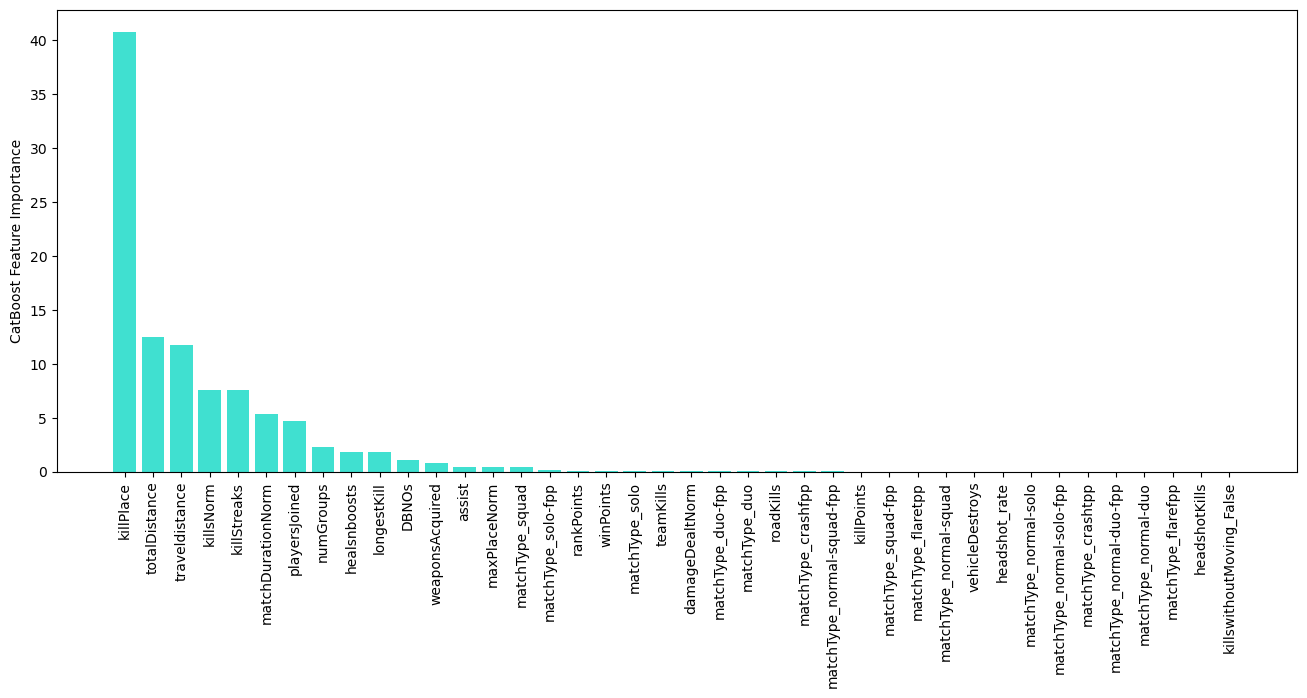

In [70]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color='turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()

## Prediction

In [71]:
pred = model.predict(xtest)

In [72]:
rmse = np.sqrt(mean_squared_error(ytest, pred))
r2 = r2_score(ytest, pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.08
R2: 0.93
